<a href="https://colab.research.google.com/github/wicky818/UTKFace_Deep_Learning/blob/main/UTKFace_DeepLearning_Gender_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -q
!pip install tensorflow==2.7.0

     |████████████████████████████████| 1.8 MB 9.1 MB/s 
     |████████████████████████████████| 181 kB 89.7 MB/s 
     |████████████████████████████████| 145 kB 91.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 665.5 MB 420 kB/s
     |████████████████████████████████| 463 kB 7.9 MB/s 
     |████████████████████████████████| 1.3 MB 60.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorfl

# Getting Data

In [ ]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning.git

Cloning into 'UTKFace_Deep_Learning'...
remote: Enumerating objects: 23341, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 23341 (delta 4), reused 18 (delta 4), pack-reused 23323
Receiving objects: 100% (23341/23341), 110.66 MiB | 32.77 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (33490/33490), done.


In [ ]:
!ls

sample_data  UTKFace_Deep_Learning


In [ ]:
import os

os.chdir("/content/UTKFace_Deep_Learning")
images = os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')
print('Total number of images: ', len(images))

Total number of images:  23708


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

# Loading Data

[age] is an integer from 0 to 116, indicating the age\
[gender] is either 0 (male) or 1 (female)\
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).\
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [ ]:
images = []
ages = []
genders = []
race = []

for i in os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')[0:5000]:
    split = i.split('_')
    ages.append((split[0]))
    genders.append((split[1]))
    race.append((split[2]))

    images.append(Image.open('/content/UTKFace_Deep_Learning/dataset/UTKFace/' + i))

In [ ]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
race = pd.Series(list(race), name = 'Races')

df = pd.concat([images, ages, genders, race], axis=1)

In [ ]:
df["Races"].unique()

array(['0', '1', '4', '3', '2', '20170109142408075.jpg.chip.jpg',
       '20170116174525125.jpg.chip.jpg'], dtype=object)

In [ ]:
# Cleanup bad data points without "Races"

df.drop(df[df["Races"] == "20170116174525125.jpg.chip.jpg"].index, inplace = True)
df.drop(df[df["Races"] == '20170109142408075.jpg.chip.jpg'].index, inplace = True)
df.drop(df[df["Races"] == '20170109150557335.jpg.chip.jpg'].index, inplace = True)

In [ ]:
df['Ages'] = df['Ages'].astype(int)
df['Genders'] = df['Genders'].astype(int)
df['Races'] = df['Races'].astype(int)

In [ ]:
df["Races"].unique()

array([0, 1, 4, 3, 2])

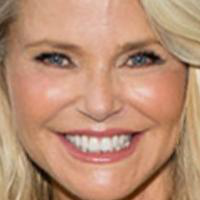

54 1 0


In [ ]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0], df['Races'][0])

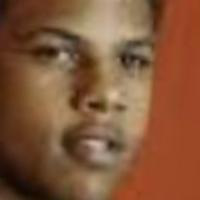

20 0 1


In [ ]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1], df['Races'][1])

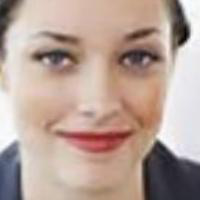

28 1 0


In [ ]:
display(df['Images'][2])
print(df['Ages'][2], df['Genders'][2], df['Races'][2])

# Exploratory Data Analysis

In [ ]:
df.head()

,Images,Ages,Genders,Races
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,54,1,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,20,0,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,1,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,55,0,4
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,20,0,3


In [ ]:
df.Races.unique()

array([0, 1, 4, 3, 2])

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


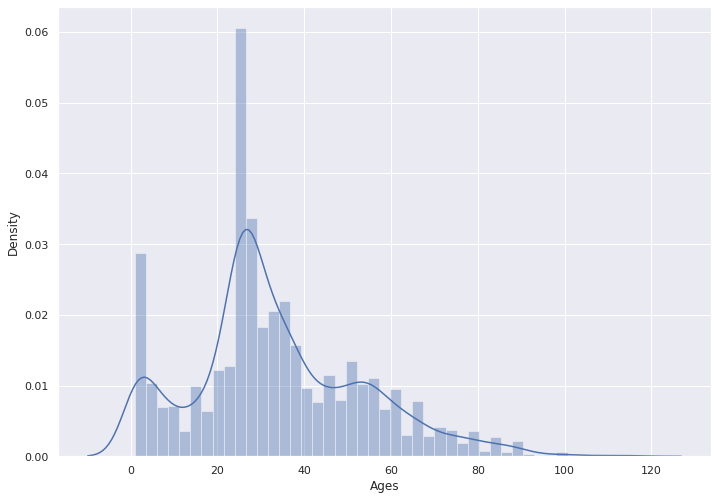

In [ ]:
sns.distplot(df["Ages"])

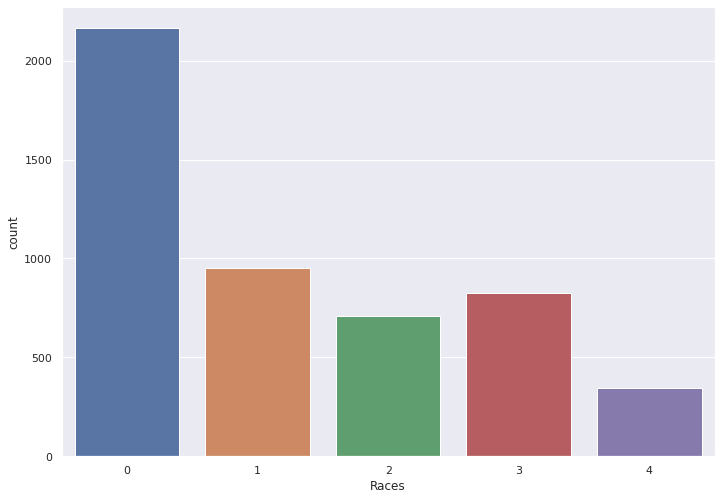

In [ ]:
sns.countplot(x = "Races", data = df)

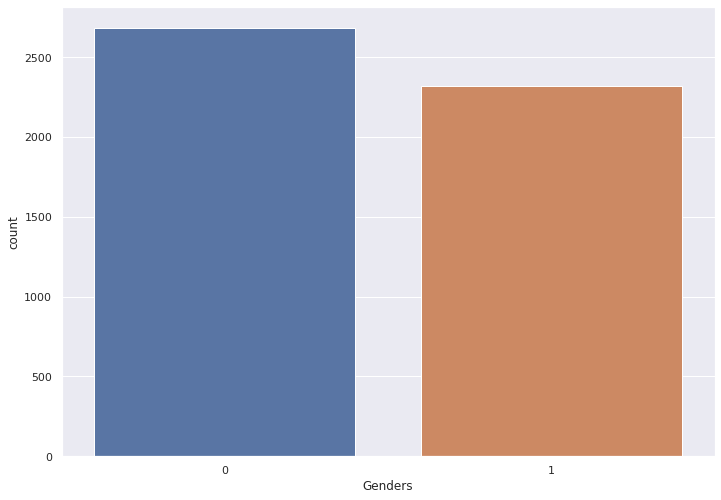

In [ ]:
sns.countplot(x = "Genders", data = df)

# Age Prediction

In [ ]:
df.shape

(4998, 4)

In [ ]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i]), int(df['Races'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
x.shape

(4998, 200, 200, 3)

In [ ]:
len(y)

4998

In [ ]:
df.to_csv("data.csv", index=None)
np.save('file_name', x)

In [ ]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning/dataset.git
!cd dataset.git

fatal: destination path 'dataset' already exists and is not an empty directory.
/bin/bash: line 0: cd: dataset.git: No such file or directory


In [ ]:
y_age = df['Ages']
y_gender = df['Genders']
y_race = df['Races']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=85)


In [ ]:
y_train_age.shape

(3998,)

x_train_age.shape

In [ ]:
x_train_age.shape

(3998, 200, 200, 3)

In [ ]:
y_train_age

4569    33
446     30
3572    35
4323    41
2269    35
        ..
1441    47
975     40
1573    28
1587    18
4459     4
Name: Ages, Length: 3998, dtype: int64

In [ ]:
x_train_age = x_train_age.astype(int)

# Modeling


In [ ]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(layers.Flatten())
agemodel.add(layers.BatchNormalization())
agemodel.add(layers.Dense(128, activation='relu'))
agemodel.add(layers.Dropout(0.5))
agemodel.add(layers.BatchNormalization())
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
agemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [ ]:
x_train_age.shape

(3998, 200, 200, 3)

In [ ]:
y_train_age.shape

(3998,)

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

x_train_mod_age,x_val_age, y_train_mod_age, y_val_age = train_test_split(x_train_age, y_train_age, test_size=0.2, random_state=85)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_mod_age, y_train_mod_age, batch_size=32)

test1 = test_datagen.flow(
        x_val_age, y_val_age,
        batch_size=32)


history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data = test1, 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/50
100/100 [==============================] - 26s 259ms/step - loss: 300.0707 - accuracy: 0.0438 - val_loss: 313.2877 - val_accuracy: 0.0220
Epoch 2/50
100/100 [==============================] - 25s 254ms/step - loss: 301.1227 - accuracy: 0.0397 - val_loss: 355.8741 - val_accuracy: 0.0480
Epoch 3/50
100/100 [==============================] - 26s 258ms/step - loss: 279.4545 - accuracy: 0.0397 - val_loss: 225.6877 - val_accuracy: 0.0480
Epoch 4/50
100/100 [==============================] - 28s 275ms/step - loss: 282.8282 - accuracy: 0.0413 - val_loss: 233.2534 - val_accuracy: 0.0480
Epoch 5/50
100/100 [==============================] - 26s 260ms/step - loss: 267.4565 - accuracy: 0.0400 - val_loss: 268.3180 - val_accuracy: 0.0470
Epoch 6/50
100/100 [==============================] - 25s 246ms/step - loss: 281.5622 - accuracy: 0.0413 - val_loss: 483.4664 - val_accuracy: 0.0100
Epoch 7/50
100/100 [==============================] - 24s 237ms/step - loss: 291.7297 - accuracy: 0.0435 -

In [ ]:
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, random_state=85)
x_train_race, x_test_race, y_train_race, y_test_race = train_test_split(x, y_race, test_size=0.2, random_state=85)

# Gender Model

In [ ]:
gendermodel = Sequential()
gendermodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
gendermodel.add(MaxPooling2D((2,2)))
gendermodel.add(Conv2D(64, (3,3), activation='relu'))
gendermodel.add(MaxPooling2D((2,2)))
gendermodel.add(Conv2D(128, (3,3), activation='relu'))
gendermodel.add(MaxPooling2D((2,2)))

gendermodel.add(layers.Flatten())
gendermodel.add(layers.BatchNormalization())
gendermodel.add(layers.Dense(128, activation='relu'))
gendermodel.add(layers.Dropout(0.5))
gendermodel.add(Dense(1, activation='sigmoid'))

gendermodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

x_train_mod_gender,x_val_gender, y_train_mod_gender, y_val_gender = train_test_split(x_train_gender, y_train_gender, test_size=0.2, random_state=85)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_mod_gender, y_train_mod_gender, batch_size=32)

test2 = test_datagen.flow(
        x_val_gender, y_val_gender,
        batch_size=32)


history1 = gendermodel.fit(train2, epochs=50, shuffle=True, validation_data = test2, 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/50
100/100 [==============================] - 24s 235ms/step - loss: 0.3834 - accuracy: 0.8240 - val_loss: 0.4084 - val_accuracy: 0.8200
Epoch 2/50
100/100 [==============================] - 24s 238ms/step - loss: 0.3793 - accuracy: 0.8258 - val_loss: 0.3940 - val_accuracy: 0.8300
Epoch 3/50
100/100 [==============================] - 24s 240ms/step - loss: 0.3861 - accuracy: 0.8286 - val_loss: 0.3507 - val_accuracy: 0.8537
Epoch 4/50
100/100 [==============================] - 24s 236ms/step - loss: 0.3738 - accuracy: 0.8305 - val_loss: 0.3495 - val_accuracy: 0.8313
Epoch 5/50
100/100 [==============================] - 24s 236ms/step - loss: 0.3654 - accuracy: 0.8365 - val_loss: 0.3483 - val_accuracy: 0.8425


In [ ]:
loss, accuracy = gendermodel.evaluate(x_test_gender, y_test_gender)
print('test set accuracy: ', accuracy * 100, "%")

32/32 [==============================] - 0s 8ms/step - loss: 148.3587 - accuracy: 0.7450
test set accuracy:  74.50000047683716 %


In [ ]:
train_losses = history1.history["loss"]
train_accs = history1.history["accuracy"]
val_losses = history1.history["val_loss"]
val_accs = history1.history["val_accuracy"]
epochs = len(train_losses)

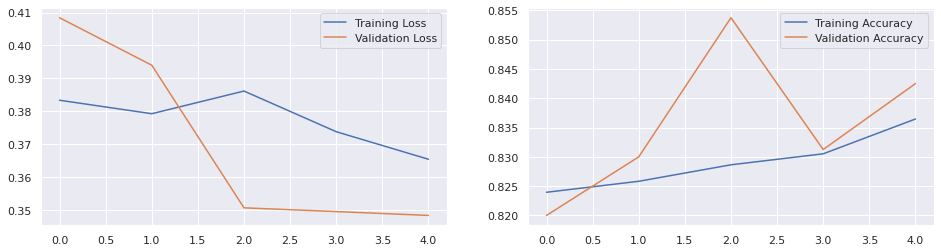

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()